### Import Modules and Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.grid_search import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
np.random.seed(42)

### Import Train and Test DataFrame

In [3]:
train_df = pd.read_csv('../data/train_modeling.csv', index_col='Id')
test_df = pd.read_csv('../data/test_modeling.csv', index_col='Id')

### Set up X and y

In [4]:
X = train_df.drop(columns='saleprice', axis=1)
y = train_df['saleprice']

**Drop saleprice from Train Data Set before GridSearch**

In [5]:
train_df.drop('saleprice', axis=1, inplace=True)

# Linear Regression

### Train/Test Split and Scale Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [7]:
lr = LinearRegression()

In [8]:
lr.fit(X_train_sc, y_train)
lr.score(X_train_sc, y_train), lr.score(X_test_sc, y_test)

(0.9409043050990836, -1.1567067871919382e+24)

In [9]:
mean_squared_error(y_train, lr.predict(X_train_sc)) ** 0.5, mean_squared_error(y_test,lr.predict(X_test_sc)) ** 0.5

(18856.161128945005, 8.979829382409078e+16)

I am basing the success of my models on the RMSE metric.  The RMSE represents the sample standard deviation of the differences between predicted values and observed values, which are called residuals. 

The linear regression model alone does not work with this data.  A RMSE of 8.979829382409078e+16 demonstrates how innacurate this model's prediction is.

# Lasso

For a dataset with a lot of features where the test score is significantly worse than the training score, then there is a problem of over-generalization or over-fitting.  Regularization provides a simple technique to reduce model complexity, prevent over-fitting which may result from simple linear regression and minimize and/or zero-out beta coefficients for multiple features to enhance the prediction accuracy and interpretability of the statistical model it produces.

Lasso is a regularization technique that is used when we have strong multicolinearity amongst the selected feature variables. Lasso shrinks the poor performing feature’s coefficient to zero thus, removing some features altogether. This works well for feature selection in cases where there is are a lot of features.

In [10]:
ss = StandardScaler()
var_thresh = VarianceThreshold()
kbest = SelectKBest(f_regression)
lasso = Lasso()

pipe = Pipeline([
    ('ss', ss),
    ('var_thresh', var_thresh),
    ('kbest', kbest),
    ('lasso', lasso)
])
    
params = {
    'var_thresh__threshold': [0, .05, .1],
    'kbest__k': [10, 15, 20],
    'lasso__alpha': np.logspace(-3,3,7)
    }

    
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)
gs_lasso = GridSearchCV(pipe, param_grid=params, cv=2)
gs_lasso.fit(X_train, y_train)
print('train score:', gs_lasso.score(X_train, y_train))
print('test score:', gs_lasso.score(X_test, y_test))
print('best score:', gs_lasso.best_score_)
print('best params:', gs_lasso.best_params_)

train score: 0.8785472849173263
test score: 0.8884595835001629
best score: 0.8739329511865491
best params: {'kbest__k': 20, 'lasso__alpha': 10.0, 'var_thresh__threshold': 0}


### Visualizing the Coefficients

I want to provide a visualization demonstrating the features that are most important in my model and what their coefficients are. The following code gets all of the beta coefficients of our model and the names of the features associated with the coefficients.

In [11]:
gs_lasso.best_estimator_.named_steps['lasso'].coef_

array([12832.28487463,  4907.0204197 ,  3653.20145381,  3488.6188906 ,
       10770.1152477 , -3416.85279243,  5147.73108481, -1800.8238497 ,
        8836.99633747, 24046.79313348,  4235.584727  ,  7218.41565741,
       -1532.70227062,   780.60076578,  7329.22359032,  -537.80656891,
        2258.78507328,  8015.88418784, -2164.93670079,   942.21606343])

In [47]:
columns = train_df.columns
columns = columns[gs_lasso.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs_lasso.best_estimator_.named_steps['kbest'].get_support()]

lasso_df = pd.DataFrame(gs_lasso.best_estimator_.named_steps['lasso'].coef_, 
             index = columns, 
             columns=['Coef Weights'])

lasso_df.sort_values('Coef Weights', ascending=False)

,Coef Weights
total_area,24046.793133
overall_qual,12832.284875
gr_liv_area,10770.115248
garage_area,8836.996337
kitchen_qual_Ex,8015.884188
bsmt_qual_Ex,7329.223590
exter_qual_Ex,7218.415657
fireplaces,5147.731085
year_built,4907.020420
total_bath,4235.584727


In [13]:
beta_0 = gs_lasso.best_estimator_.named_steps['lasso'].intercept_

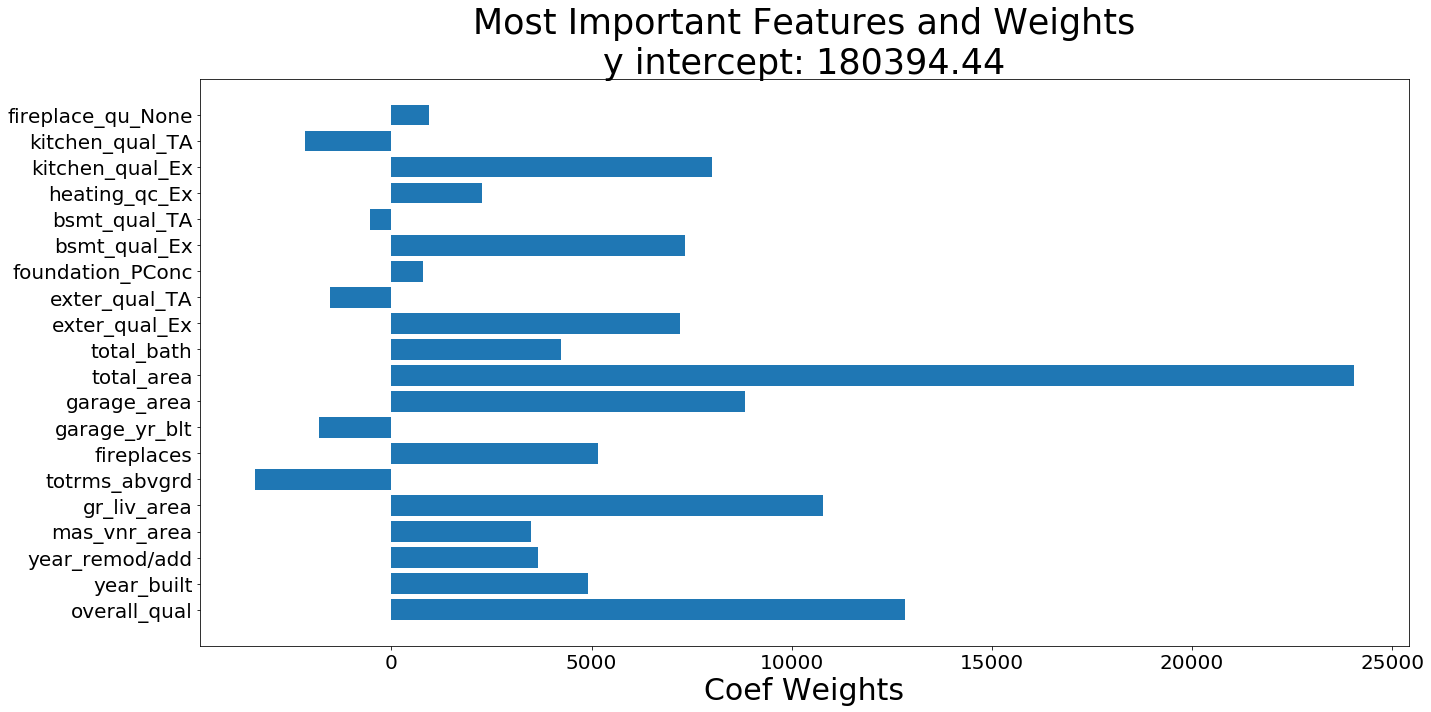

In [14]:
plt.figure(figsize=(20,10))
plt.barh(lasso_df.index, lasso_df['Coef Weights'])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Coef Weights', fontsize=30)
plt.title('Most Important Features and Weights\ny intercept: {:0.02f}'.format(beta_0), fontsize=35)
plt.tight_layout()

### Predict the Model

In [15]:
np.sqrt(mean_squared_error(y_test, gs_lasso.predict(X_test)))

27885.12361648533

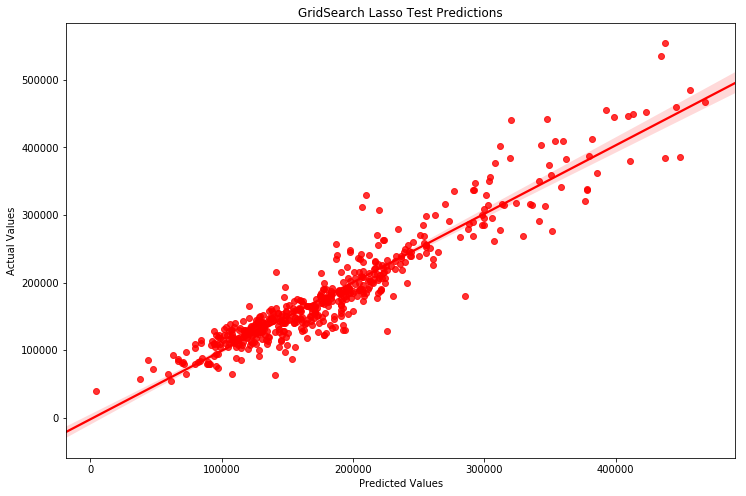

In [16]:
plt.figure(figsize=(12,8))
sns.regplot(gs_lasso.predict(X_test), y_test, color='red')
plt.title("GridSearch Lasso Test Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values");

This plot demonstrates a much more accurate model prediction than the Linear Regression model.  The RMSE of 27885.12 means that the predicted scores are on average +/- 27885.12 off of the actual scores.

# Ridge

Ridge regularization differs from Lasso in that it enforces the beta coefficients to be lower, but it does not enforce them to be zero. That is, it will not get rid of irrelevant features but rather minimize their impact on the trained model.

I will run through the same steps with Ridge that I did with Lasso.

In [17]:
ss = StandardScaler()
var_thresh = VarianceThreshold()
kbest = SelectKBest(f_regression)
ridge = Ridge()

pipe = Pipeline([
    ('ss', ss),
    ('var_thresh', var_thresh),
    ('kbest', kbest),
    ('ridge', ridge)
])
    
params = {
    'var_thresh__threshold': [0, .05, .1],
    'kbest__k': [10, 15, 20],
    'ridge__alpha': np.logspace(-3,3,7)
    }

    
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)
gs_ridge = GridSearchCV(pipe, param_grid=params, cv=2)
gs_ridge.fit(X_train, y_train)
print('train score:', gs_ridge.score(X_train, y_train))
print('test score:', gs_ridge.score(X_test, y_test))
print('best score:', gs_ridge.best_score_)
print('best params:', gs_ridge.best_params_)

train score: 0.8785356861566722
test score: 0.8884554787654789
best score: 0.873990409356243
best params: {'kbest__k': 20, 'ridge__alpha': 10.0, 'var_thresh__threshold': 0}


### Visualizing the Coefficients

In [18]:
gs_ridge.best_estimator_.named_steps['ridge'].coef_

array([12772.85438435,  4863.3254911 ,  3640.5329418 ,  3545.2814084 ,
       10862.18219879, -3263.81281756,  2128.00624102, -1719.11653208,
        8845.16446791, 23598.32209713,  4298.23636197,  7218.78969575,
       -1601.79345183,   807.23516183,  7339.9035678 ,  -530.4190662 ,
        2256.91873031,  8009.98819868, -2202.47784314, -2128.00624102])

In [19]:
columns = train_df.columns
columns = columns[gs_ridge.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs_ridge.best_estimator_.named_steps['kbest'].get_support()]

ridge_df = pd.DataFrame(gs_ridge.best_estimator_.named_steps['ridge'].coef_, 
             index = columns, 
             columns=['Coef Weights'])

ridge_df

,Coef Weights
overall_qual,12772.854384
year_built,4863.325491
year_remod/add,3640.532942
mas_vnr_area,3545.281408
gr_liv_area,10862.182199
totrms_abvgrd,-3263.812818
fireplaces,2128.006241
garage_yr_blt,-1719.116532
garage_area,8845.164468
total_area,23598.322097


In [20]:
beta_0 = gs_ridge.best_estimator_.named_steps['ridge'].intercept_

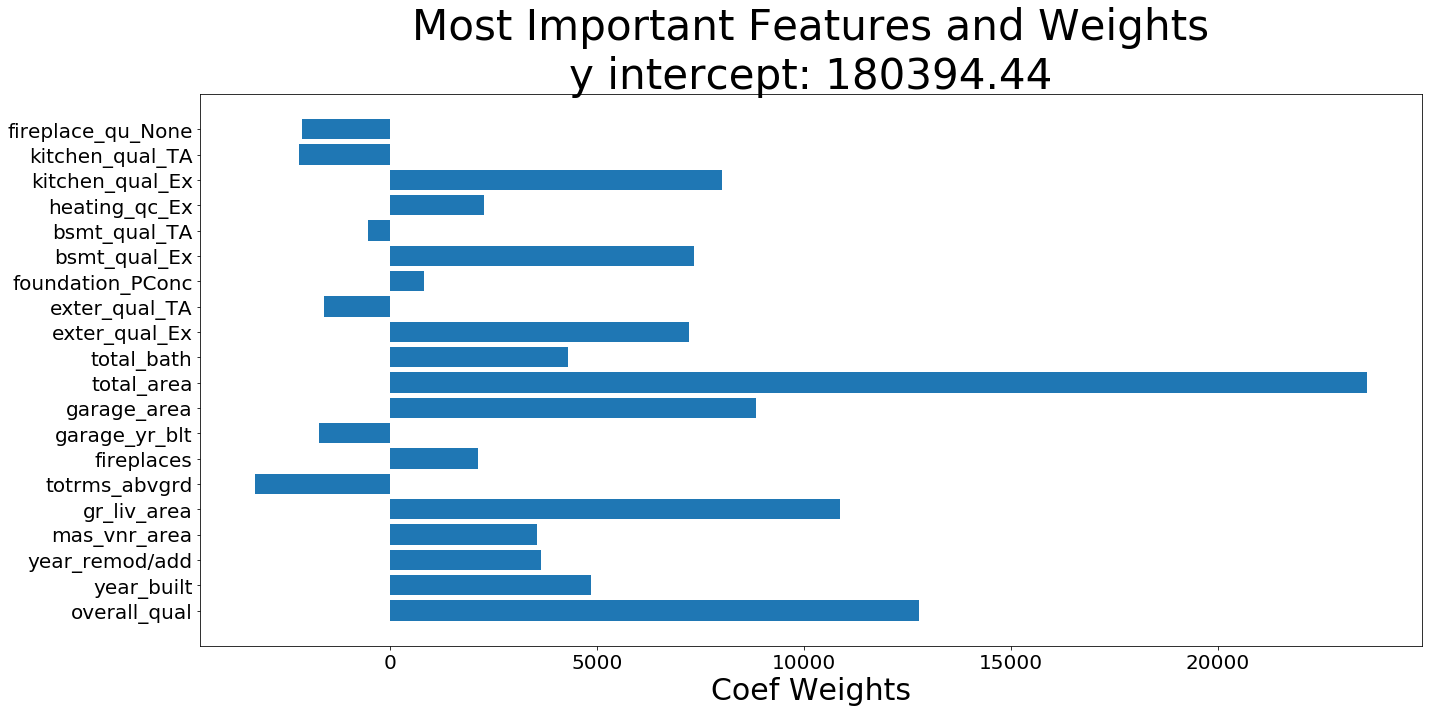

In [21]:
plt.figure(figsize=(20,10))
plt.barh(ridge_df.index, ridge_df['Coef Weights'])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Coef Weights', fontsize=30)
plt.title('Most Important Features and Weights\ny intercept: {:0.02f}'.format(beta_0), fontsize=42)
plt.tight_layout()

### Predict the Model

In [22]:
np.sqrt(mean_squared_error(y_test, gs_ridge.predict(X_test)))

27885.636703959033

In [23]:
gs_ridge_prediction_test = gs_ridge.predict(X_test)

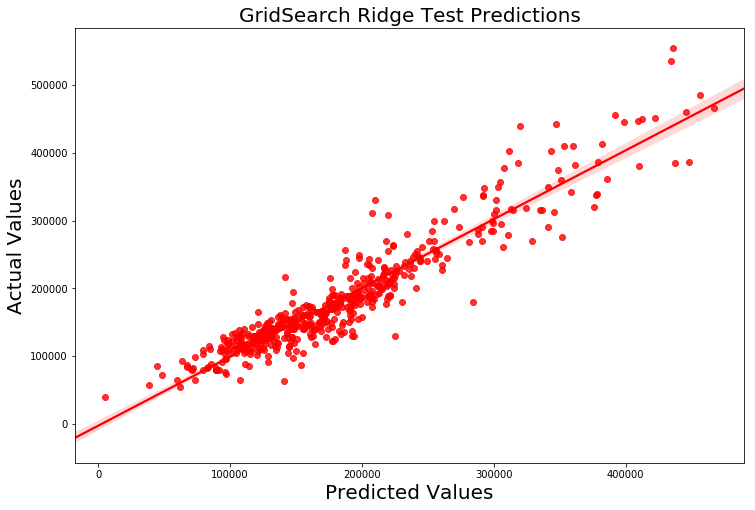

In [24]:
plt.figure(figsize=(12,8))
sns.regplot(gs_ridge_prediction_test, y_test, color='red')
plt.title("GridSearch Ridge Test Predictions", fontsize=20)
plt.xlabel("Predicted Values", fontsize=20)
plt.ylabel("Actual Values", fontsize=20);

In terms of the RMSE score, this model performs just $slightly$ worse than Lasso.  

## Make Predictions

**Linear Prediction**

In [25]:
pred_lr = lr.predict(test_df)

In [26]:
pred_lr_exp = np.expm1(pred_lr)

In [27]:
final_lr_df = pd.DataFrame(pred_lr_exp, index=test_df.index)

In [28]:
final_lr_df.columns = ['saleprice']

In [29]:
final_lr_df.sort_index(inplace=True)

In [30]:
final_lr_df.to_csv('../data/final_lr.csv')

In [31]:
!head ../data/final_lr.csv

Id,saleprice
2,-1.0
4,-1.0
6,-1.0
7,-1.0
17,-1.0
18,-1.0
22,-1.0
27,-1.0
31,-1.0


**Lasso Prediction**

In [32]:
pred_lasso_gs = gs_lasso.predict(test_df)

In [33]:
pred_lasso_gs_exp = np.expm1(pred_lasso_gs)

In [34]:
final_lasso_gs_df = pd.DataFrame(pred_lasso_gs_exp, index=test_df.index)

In [35]:
final_lasso_gs_df.columns = ['SalePrice']

In [36]:
final_lasso_gs_df.sort_index(inplace=True)

In [37]:
final_lasso_gs_df.to_csv('../data/final_gs_lasso.csv')

In [38]:
!head ../data/final_gs_lasso.csv

Id,SalePrice
2,inf
4,inf
6,inf
7,inf
17,inf
18,inf
22,inf
27,inf
31,inf


**Ridge Prediction**

In [39]:
pred_ridge_gs = gs_ridge.predict(test_df)

In [40]:
pred_ridge_gs_exp = np.expm1(pred_ridge_gs)

In [41]:
final_ridge_gs_df = pd.DataFrame(pred_ridge_gs_exp, index=test_df.index)

In [42]:
final_ridge_gs_df.columns = ['saleprice']

In [43]:
final_ridge_gs_df.sort_index(inplace=True)

In [44]:
final_ridge_gs_df.to_csv('../data/final_gs_ridge.csv')

In [45]:
!head ../data/final_gs_ridge.csv

Id,saleprice
2,inf
4,inf
6,inf
7,inf
17,inf
18,inf
22,inf
27,inf
31,inf


## Conclusion

OLS regression does not address the problem of multicollinearity.  Therefore, I used the ridge and lasso regularization techniques to deal with this issue.  In ridge regression the weights for attributes cannot exceed a certain constant. Because of this, ridge regression models have significantly less error than OLS regression.  This was proven in my modeling as the ridge regression had a RMSE of 0.13 while the OLS regression had a RMSE score 0.14.  Lasso also deals with multicollinearity by zeroing out the less effective variable.  Lasso performed the best out of my three models and its RMSE was a bit lower than the ridge RMSE.  

I think I can continue to improve my model through better feature engineering and subset selection.  The most important features in all of my models were 'overall_quality', 'total_area', 'gr_liv_area', garage area', 'year_remodele/add' and 'year_built'.  I could run my models with these as the only features to see if it improves their accuracy.  I can also do more feature engineering to try and reduce the number of redundant variables, especially after I got dummies of all my categorical columns.  Finally, I might consider log transforming individual features that had above 0.7 or 0.8 in order to make their distributions closer to normal.